In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import statistics
import itertools
import time
import copy
import multiprocessing

In [4]:
class Cell:
  
  def __init__(self, state=0, previous_state=None):
    self._state = state
    self._previous_state = previous_state

  def set_state(self, state):
    self._previous_state = self._state
    self._state = state
    return self._previous_state

  def get_state(self):
    return self._state
    
  def get_previous_state(self):
    return self._previous_state

  def __str__(self):
    return self._state
    

In [5]:
class Mujik:

  def __init__(self, hp=100, x=0, y=0):
    self._hp = hp
    self._x = x
    self._y = y

  def get_location(self):
    return self._x, self._y

  def get_hp(self):
    return self._hp

  def change_hp(self, amount=1):
    self._hp += amount

  def move_up(self, d=1):
    self._y -= d
    
  def move_down(self, d=1):
    self._y += d
    
  def move_left(self, d=1):
    self._x -= d

  def move_right(self, d=1):
    self._x += d

In [6]:
class GameField():
  _N = 10
  _EXPLOSION_COUNT = 7
  _EXPLOSION_RADIUS = 1
  _BASE_DELAY = _EXPLOSION_RADIUS + 1
  _EXPLOSION_DELAY = 0
  _EXPLOSION_DURATION = 2
  _EXPLOSIONS_ADD_PER_TICK = _EXPLOSION_COUNT / _EXPLOSION_DURATION
  _DAMAGE = {0: 0, 1: 0, 2: 25, 3: 50, 4: 75}
  _TYPE_OF_CELL_STATES = {
    -1: 'out_of_bounds',
    0: 'white',  # no effect
    1: 'purple', # dangerous
    2: 'yellow', # low damage
    3: 'orange', # mid damage
    4: 'red'     # high damage
    }

  def __init__(self):
    self._player = Mujik(x=int(random.random()*self._N), 
                         y=int(random.random()*self._N))
    self._active = {} # (x,y): [state, time_to_live]
    self._field = [[] for el in range(self._N)]
    self._action = 0
    self._ACTIONS_PROCESSOR = {0: self.process_hold, 1: self.process_move_up, 
                     2: self.process_move_down, 3: self.process_move_left, 
                     4:self.process_move_right}
    for i in range(self._N):
      for j in range(self._N):
        self._field[i].append(Cell())
  
  def mark_area(self, x, y, state=0):
    if x > self._N-1 or x < 0:
      raise IndexError('x is out of bounds!')
    if y > self._N-1 or y < 0:
      raise IndexError('y is out of bounds!')

    buf_size = self._EXPLOSION_RADIUS*2 + 1
    buffer = np.zeros((buf_size,buf_size), int)
    centre = [int(buf_size/2), int(buf_size/2)]

    if state == 2: 
      buffer[centre[0]][centre[1]] = 4
      shifts = list(filter(lambda xx: abs(xx[0]) != abs(xx[1]),
                set(itertools.combinations([0, 1, -1, 0], 2))))
      for shift in shifts:
        buffer[centre[0]+shift[0]][centre[1]+shift[1]] = 3
    
    for i in range(buf_size):
      for j in range(buf_size):
        if buffer[i][j] == 0:
          buffer[i][j] = state
    
    if state == 1:
      self._active[(x, y)] = [state, self._BASE_DELAY + self._EXPLOSION_DELAY]
    elif state in(2, 3, 4):
      self._active[(x, y)] = [state, self._EXPLOSION_DURATION]

    x_start = x - centre[0]
    y_start = y - centre[1]
    for i in range(x_start, x_start+buf_size):
      for j in range(y_start, y_start+buf_size):
        if i > self._N-1 or i < 0 or j > self._N-1 or j < 0:
          continue
        self._field[i][j].set_state(buffer[i-x_start][j-y_start])


  def tick(self):
    #UPDATE ACTIVES
    if len(self._active) > 0:
      to_delete = []
      for (x, y), [state, time_to_live] in self._active.items():
        if time_to_live > 1:
          self._active[(x,y)] = [state, time_to_live - 1]
        else:
          if state == 1:
            self.mark_area(x, y, 2)
            self._active[(x,y)] = [2, self._EXPLOSION_DURATION]
          elif state in (2, 3, 4):
            self.mark_area(x, y, 0)
            to_delete.append((x, y))
      for (x, y) in to_delete:
        del self._active[(x,y)]
    
    #ADD NEW DANGERS (BECOME EXPLOSIONS)
    if len(self._active) == 0:
      generated_active = []
      counter = 0
      while(len(generated_active) < self._EXPLOSION_COUNT):
        counter += 1
        if counter % 100000 == 0:
          generated_active.append((new_x, new_y))
          break
        if counter % 1000000 == 0:
          print(f'generated_active {generated_active}')
          print(f'new_x {new_x}')
          print(f'new_y {new_y}')
          raise TimeoutError('I am stuck at tick()')
        new_x = int(random.random()*self._N)
        new_y = int(random.random()*self._N)
        if len(generated_active) != 0:
          flag = False
          for x, y in generated_active:
            if abs(new_x - x) < 2*self._EXPLOSION_RADIUS + 1 and \
            abs(new_y - y) < 2*self._EXPLOSION_RADIUS + 1:
              flag = True
              break
          if not flag:
            generated_active.append((new_x, new_y))
        else:
          generated_active.append((new_x, new_y))
        # print(generated_active)
      
      for (x, y) in generated_active:
        self.mark_area(x, y, 1)
    
    #PROCESS PLAYER
    action_result = self._ACTIONS_PROCESSOR[self._action]()
    player_x, player_y = self._player.get_location()
    damage = -1*self._DAMAGE[self._field[player_x][player_y].get_state()]
    regen = 0
    self._player.change_hp(damage)
    if self._player.get_hp() < 100:
      self._player.change_hp(1) # REGEN
      regen = 1
    # print(f'HP Change({damage+regen}): damage = {damage}, regen = {regen}')
    return action_result, self._player.get_hp() > 0

  
  def set_action(self, action):
    self._action = action

  def process_move_up(self):
    x, y = self._player.get_location()
    if y - 1 >= 0:
      self._player.move_up()
      return 0
    return 1

  def process_move_down(self):
    x, y = self._player.get_location()
    if y + 1 <= self._N - 1:
      self._player.move_down()
      return 0
    return 1

  def process_move_left(self):
    x, y = self._player.get_location()
    if x - 1 >= 0:
      self._player.move_left()
      return 0
    return 1

  def process_move_right(self):
    x, y = self._player.get_location()
    if x + 1 <= self._N - 1:
      self._player.move_right()
      return 0
    return 1

  def process_hold(self):
    return 0

  def get_active(self):
    return self._active

  def get_field(self):
    return self._field

  def print_field(self):
    x, y = self._player.get_location()
    for j in range(self._N):
      for i in range(self._N):
        ender = '  '
        if i == x and j == y:
          ender = 'p '
        print(self._field[i][j].get_state(), end=ender)
      print('')

  def get_player(self):
    return(self._player)

  def get_player_locality(self):
    x, y = self._player.get_location()
    shifts = list(set(itertools.combinations([-1, 0, 1, -1, 0, 1], 2)))
    shifts.sort()
    result = np.reshape([self._field[x+xn][y+yn].get_state() 
            if x+xn in range(10) and y+yn in range(10) else -1 
            for (xn, yn) in shifts], (3, 3)).transpose()
    return tuple(tuple(el for el in sub) for sub in result)


In [7]:
class Agent():
  _ACTIONS = [0, 1, 2, 3, 4]


  def __init__(self, policy, state, born_iteration=0):
    self._reward = 0
    self._policy = policy
    self._state = state
    self._previous_state = state
    self._choice_history = []
    self._born = born_iteration

  def make_action(self, state):
    self._previous_state = self._state
    self._state = state
    action = 0
    try:
      distribution = self._policy[self._state]
    except KeyError:
      self._policy[self._state] = {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4:0.2}
      distribution = self._policy[self._state]
    action = np.random.choice(list(distribution.keys()), 
                                p=list(distribution.values()))
    
    self._choice_history.append((self._state, 
                                 action, self._reward))
    return action, self._policy

  def age(self, last_iteration):
    return last_iteration - self._born

  
  def update_reward(self, amount):
    self._reward += amount

  def get_policy(self):
    return self._policy

  def get_reward(self):
    return self._reward

  def get_history(self):
    return self._choice_history

In [8]:
def worker(argument):

  const_policy, iterations, MAX_LIVING_TIME = \
  argument[0], argument[1], argument[2]

  indices_rewards_hisoties_living_times = []
  gfield = GameField()
  agent = Agent(const_policy, gfield.get_player_locality())
  for i in range(iterations):
    action, policy = agent.make_action(gfield.get_player_locality())
    gfield.set_action(action)
    action_result, is_alive = gfield.tick()
    x, y = gfield.get_player().get_location()
    hp = gfield.get_player().get_hp()
    agent.update_reward(float(hp/100)-action_result*10)
    if not is_alive or agent.age(i) >= MAX_LIVING_TIME:
      indices_rewards_hisoties_living_times.append([i, agent.get_reward(), 
                                                      agent.get_history(),
                                                      agent.age(i)])
      gfield = GameField()
      agent = Agent(const_policy, gfield.get_player_locality(), i)
  return const_policy, indices_rewards_hisoties_living_times

In [55]:
POLICY = {}

In [56]:
N_EPOCHS = 300

In [57]:
times_stats = []
rewards_stats = []
gamma = 0.5
for i in range(N_EPOCHS):
  ### Start simulation
  N_ITERATIONS = 5000
  MAX_LIVING_TIME = 100
  with multiprocessing.Pool(10) as pool:
    results = pool.map(worker, [(POLICY, N_ITERATIONS, MAX_LIVING_TIME) 
    for el in range(10)]) # [[policy0, history0],]
  ###

  ### Pre-Process new policy and history
  POLICY = {k: v for sub in results for k, v in sub[0].items()}
  indices_rewards_hisoties_living_times = [el for sub in results for el in sub[1]]

  ELITE_PART = 0.25
  indices_rewards_hisoties_living_times.sort(key=lambda x: x[1])
  elite_index = int(ELITE_PART*indices_rewards_hisoties_living_times.__len__())
  elite_sessions = indices_rewards_hisoties_living_times[-elite_index:]

  history = [(el[0], el[1]) for sub in elite_sessions for el in sub[2]]

  # Some statistics
  living_time = [el[-1] for el in indices_rewards_hisoties_living_times]
  rewards = [el[1] for el in indices_rewards_hisoties_living_times]
  print(f'Iteration #{i}')
  max_lt, min_lt, mean_lt = max(living_time),\
   min(living_time), statistics.mean(living_time)
  max_rwd, min_rwd, mean_rwd = max(rewards),\
   min(rewards), statistics.mean(rewards)
  times_stats.append([max_lt, min_lt, mean_lt])
  rewards_stats.append([max_rwd, min_rwd, mean_rwd])

  if min_lt >= MAX_LIVING_TIME:
    print('Model is saturated!')
    break

  print(f'Living times are: max={max_lt} min={min_lt} mean={mean_lt}')
  print(f'Rewards are: max={max_rwd} min={min_rwd} mean={mean_rwd}')
  print()
  ###

  ### Update policy
  choice_stats = dict.fromkeys([el[0] for el in history], [0, [0, 0, 0, 0, 0]])
  # Calculate count of each action taken for every state 
  # and num of times agent was in that state
  for state, action in history:
    update_with = copy.deepcopy(choice_stats[state])
    update_with[0] += 1
    upd_action_stats = update_with[1]
    upd_action_stats[action] += 1
    update_with[1] = copy.deepcopy(upd_action_stats)
    choice_stats[state] = copy.deepcopy(update_with)

  # Normalise probabilities
  for state, value in choice_stats.items():
    new_value = [float(el/value[0]) for el in value[1]]
    choice_stats[state] = new_value
    del new_value

  # Update POLICY
  for state, distribution in choice_stats.items():
    POLICY[state] = {i:gamma*distribution[i]+(1-gamma)*POLICY[state][i] 
                     for i in range(len(distribution))}
  ###


Iteration #0
Living times are: max=63 min=3 mean=13.278073443320915
Rewards are: max=33.86 min=-117.55000000000001 mean=-2.59015167642363

Iteration #1
Living times are: max=75 min=4 mean=14.000280504908837
Rewards are: max=52.28 min=-71.75 mean=2.239643758765778

Iteration #2
Living times are: max=87 min=3 mean=15.37215033887862
Rewards are: max=53.5 min=-67.55 mean=5.434100431300061

Iteration #3
Living times are: max=80 min=4 mean=16.65554072096128
Rewards are: max=54.300000000000004 min=-35.3 mean=7.602616822429906

Iteration #4
Living times are: max=83 min=4 mean=18.650205761316872
Rewards are: max=58.61 min=-24.1 mean=9.387542087542087

Iteration #5
Living times are: max=100 min=4 mean=20.948653198653197
Rewards are: max=60.25 min=-23.140000000000004 mean=11.376426767676767

Iteration #6
Living times are: max=100 min=3 mean=23.394266917293233
Rewards are: max=71.7 min=-18.970000000000002 mean=13.205751879699248

Iteration #7
Living times are: max=100 min=3 mean=25.46700767263427


In [59]:
times_stats = pd.DataFrame(times_stats, columns=['max_lt', 'min_lt', 'mean_lt'])
rewards_stats = pd.DataFrame(rewards_stats, columns=['max_rwd', 'min_rwd', 'mean_rwd'])

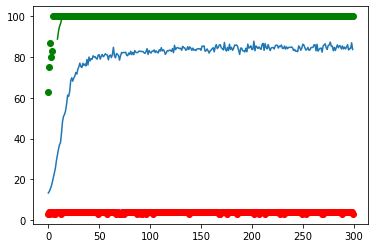

In [60]:
plt.scatter(np.arange(times_stats.max_lt.shape[0]), times_stats.max_lt, c='green')
plt.scatter(np.arange(times_stats.min_lt.shape[0]), times_stats.min_lt, c='red')
plt.plot(np.arange(times_stats.max_lt.shape[0]), times_stats.max_lt.rolling(10).mean(), 'g-')
plt.plot(np.arange(times_stats.mean_lt.shape[0]), times_stats.mean_lt)
plt.show()

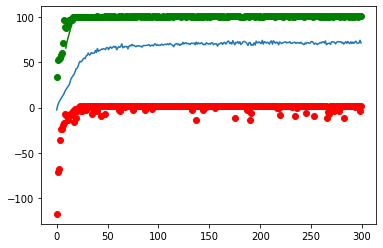

In [61]:
plt.scatter(np.arange(rewards_stats.max_rwd.shape[0]), rewards_stats.max_rwd, c='green')
plt.scatter(np.arange(rewards_stats.min_rwd.shape[0]), rewards_stats.min_rwd, c='red')
plt.plot(np.arange(rewards_stats.max_rwd.shape[0]), rewards_stats.max_rwd.rolling(10).mean(), 'g-')
plt.plot(np.arange(rewards_stats.mean_rwd.shape[0]), rewards_stats.mean_rwd)
plt.show()